# Exercício 2

## Desafio: Identificação de Títulos Semelhantes em um Conjunto de Dados

Este notebook tem como objetivo encontrar e identificar títulos semelhantes no conjunto de dados "item_titles_test.csv", utilizando técnicas de processamento de linguagem natural (NLP) sem o uso de modelos previamente treinados. A ideia é gerar uma lista ordenada por pontuação de similaridade, que permitirá identificar os pares de produtos mais semelhantes.

Considerações:
A implementação deve ser eficiente em termos de tempo de execução.
O uso de modelos previamente treinados está fora do escopo deste desafio, portanto, serão utilizadas abordagens manuais para cálculo de similaridade entre os títulos.
O foco está em construir uma solução prática que permita a análise da escalabilidade da abordagem implementada.

Estratégia de Resolução:
Para resolver o problema, será implementada manualmente a técnica TF-IDF (Term Frequency-Inverse Document Frequency), que avalia a importância de cada termo em um documento em relação a um conjunto de documentos. 

Após a vetorização dos títulos, será utilizado o cálculo da similaridade do cosseno, uma métrica que mede o grau de similaridade entre dois vetores. A similaridade do cosseno varia entre 0 e 1, onde 1 indica que os vetores (ou títulos) são idênticos. Com essa abordagem, será possível comparar os títulos do conjunto de dados e identificar quais são mais semelhantes entre si, ordenando os pares com base nas maiores pontuações de similaridade.

Além disso, a função final contará com limiar de similaridade retornada e quantidade de dados analisada.

In [ ]:
import re
import time  
import math
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib.pyplot import plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "C:/Users/danil/Desktop/Case Mercado Livre/Files/"
file_1 = "items_titles.csv"
file_2 = "items_titles_test.csv"
data_1 = pd.read_csv(path+file_1)
data_2 = pd.read_csv(path+file_2)
df1 = data_1.copy()
df2 = data_2.copy()

# Modelo

In [15]:
# Função para limpar e tokenizar o texto
def preprocess_text(text):
    
    if isinstance(text, list):
        return text  
        
    # Converte para minúsculas
    text = text.lower() 

    # Dicionário para conversão de cores femininas para masculinas
    gender_color_translation = {
        'vermelha': 'vermelho',
        'vermelhas': 'vermelho',
        'preta': 'preto',
        'pretas': 'preto',
        'amarela': 'amarelo',
        'amarelas': 'amarelo',
        'roxa': 'roxo',
        'roxas': 'roxo',
        'dourada': 'dourado',
        'douradas': 'dourado',
        'prateada': 'prateado',
        'prateadas': 'prateado'
    }
    
    # Dicionário para conversão de cores do inglês para português
    color_translation = {
        'blue': 'azul',
        'red': 'vermelho',
        'green': 'verde',
        'yellow': 'amarelo',
        'black': 'preto',
        'white': 'branco',
        'pink': 'rosa',
        'gray': 'cinza',
        'orange': 'laranja',
        'purple': 'roxo',
        'gold': 'dourado',
        'silver': 'prateado'
    }

    all_color_translations = {**gender_color_translation, **{k + 's?': v for k, v in color_translation.items()}}

    # Substituição de cores no texto
    for pattern, replacement in all_color_translations.items():
        text = re.sub(rf'\b{pattern}\b', replacement, text)

    # Remoção de números sozinhos ou sequências numéricas
    text = re.sub(r'\b\d+\b|\b\w*\d\w*\b', '', text)  # Remove números e palavras com números

    # Remoção de caracteres especiais e acentos
    text = re.sub(r'[^\w\s]', '', text)  # Remove caracteres especiais
    text = re.sub(r'á|à|â|ã|ä', 'a', text)
    text = re.sub(r'é|è|ê|ë', 'e', text)
    text = re.sub(r'í|ì|î|ï', 'i', text)
    text = re.sub(r'ó|ò|ô|õ|ö', 'o', text)
    text = re.sub(r'ú|ù|û|ü', 'u', text)
    text = re.sub(r'ç', 'c', text)

    # Remoção de letras sozinhas ou duas letras
    text = re.sub(r'\b[a-zA-Z]{1,2}\b', '', text)  # Remove letras soltas ou duas letras

    # Remoção de sequência de consoante + vogal ou consoante + vogal + consoante
    text = re.sub(r'\b[bcdfghjklmnpqrstvwxyz][aeiou][bcdfghjklmnpqrstvwxyz]?\b', '', text)

    # Remoção de palavras compostas pela mesma letra com pelo menos 3 caracteres
    text = re.sub(r'\b([a-zA-Z])\1{2,}\b', '', text)

    # Remoção de espaços em branco extras
    text = re.sub(r'\s+', ' ', text).strip()

    return text.split()

# Cálculo TF de cada termo em um texto
def compute_tf(document):
    total_terms = len(document)
    term_count = Counter(document)
    return {term: count / total_terms for term, count in term_count.items()}

# Cálculo IDF de cada termo
def compute_idf(documents):
    idf = {}
    total_documents = len(documents)
    term_document_count = Counter()

    for document in documents:
        unique_terms = set(document)
        term_document_count.update(unique_terms)

    for term, count in term_document_count.items():
        idf[term] = math.log(total_documents / (1 + count))
        
    return idf

# Cálculo TF-IDF de cada documento
def compute_tf_idf(documents):
    idf = compute_idf(documents)
    tf_idf_documents = []
    
    for document in documents:
        tf = compute_tf(document)
        tf_idf = {term: tf[term] * idf[term] for term in tf if term in idf}
        tf_idf_documents.append(tf_idf)
    
    return tf_idf_documents, idf

# Função para gerar um novo título a partir dos N termos mais importantes
def generate_title_from_top_n(tf_idf, n):
    # Obtém os N termos principais com base nos pesos TF-IDF
    top_n_terms = sorted(tf_idf.items(), key=lambda x: x[1])[:n]
    return ' '.join(term for term, weight in top_n_terms)

# Cálculo de similaridade do cosseno
def cosine_similarity(vec_a, vec_b):
    intersection = set(vec_a) & set(vec_b)
    
    if not intersection:
        return 0.0, []  # Sem termos comuns, similaridade é 0

    dot_product = sum(vec_a[term] * vec_b[term] for term in intersection)
    norm_a = math.sqrt(sum(vec_a[term]**2 for term in vec_a))
    norm_b = math.sqrt(sum(vec_b[term]**2 for term in vec_b))
    
    similarity = dot_product / (norm_a * norm_b) if norm_a and norm_b else 0.0
    return similarity, list(intersection)  # Retorna a similaridade e os termos utilizados

# Função principal
def process_dataframes(df1, df2, n, threshold=0):
    # Pré-processamento dos títulos
    df1['cleaned_titles'] = df1['ITE_ITEM_TITLE'].apply(preprocess_text)
    df2['cleaned_titles'] = df2['ITE_ITEM_TITLE'].apply(preprocess_text)

    # Cálculo do TF-IDF para ambos os DataFrames
    tf_idf_df1, _ = compute_tf_idf(df1['cleaned_titles'].tolist())
    tf_idf_df2, _ = compute_tf_idf(df2['cleaned_titles'].tolist())

    # Gerar novos títulos baseados nos N termos mais importantes
    reduced_titles_df1 = [generate_title_from_top_n(tf_idf, n) for tf_idf in tf_idf_df1]
    reduced_titles_df2 = [generate_title_from_top_n(tf_idf, n) for tf_idf in tf_idf_df2]

    # Comparar os títulos reduzidos e armazenar similaridades
    results = []
    detailed_results = []
    summary_results = []
    
    for i, title_a in enumerate(reduced_titles_df2):
        vec_a = compute_tf(preprocess_text(title_a))  # Converte título reduzido para TF
        for j, title_b in enumerate(reduced_titles_df1):
            vec_b = compute_tf(preprocess_text(title_b))  # Converte título reduzido para TF
            similarity, terms_used = cosine_similarity(vec_a, vec_b)
            if similarity >= threshold:
                results.append({
                    'df2_index': i,
                    'df1_index': j,
                    'Score(0,1)': similarity,
                    'terms_used': terms_used
                })
                detailed_results.append({
                    'df1_index': j,
                    'ITE_ITEM_TITLE(df1)': df1.iloc[j]['ITE_ITEM_TITLE'],
                    'terms_df1': preprocess_text(df1.iloc[j]['ITE_ITEM_TITLE']),
                    'df2_index': i,
                    'ITE_ITEM_TITLE(df2)': df2.iloc[i]['ITE_ITEM_TITLE'],
                    'terms_df2': preprocess_text(df2.iloc[i]['ITE_ITEM_TITLE']),
                    'Score(0,1)': similarity
                })
                summary_results.append({
                    'ITE_ITEM_TITLE(df1)': df1.iloc[j]['ITE_ITEM_TITLE'],
                    'ITE_ITEM_TITLE(df2)': df2.iloc[i]['ITE_ITEM_TITLE'],
                    'Score(0,1)': similarity
                })

    # Criação dos DataFrames
    df_similarity = pd.DataFrame(results) # Fornece informações simplificadas, como o índice das observações, similaridade e termos usados
    df_detailed = pd.DataFrame(detailed_results) # Fornece informações gerais e similaridade
    df_summary = pd.DataFrame(summary_results) # Fornece o banco de dados no formato do exercício
    
    return df_similarity, df_detailed, df_summary

In [16]:
# Início do tempo de processamento
start_time = time.time()

# Parâmetros
window = 100
n = 5  # Número de termos principais a serem mantidos
threshold = 0.2  # Threshold de similaridade

# Processar os DataFrames
df_similarity, df_detailed, df_summary = process_dataframes(df1[:window], df2[:window], n, threshold)

# Fim do tempo de processamento
end_time = time.time()

# Cálculo do tempo total
print(f'Tempo: {end_time - start_time:.2f}s')
display(df_summary)

Tempo: 3.13s


,ITE_ITEM_TITLE(df1),ITE_ITEM_TITLE(df2),"Score(0,1)"
0,Tênis Ascension Posh Masculino - Preto E Verme...,Tênis Olympikus Esporte Valente - Masculino Kids,0.400000
1,Tenis Para Caminhada Super Levinho Spider Corr...,Tênis Olympikus Esporte Valente - Masculino Kids,0.200000
2,Tênis Feminino Le Parc Hocks Black/ice Origina...,Tênis Olympikus Esporte Valente - Masculino Kids,0.200000
3,Tênis Olympikus Esportivo Academia Nova Tendên...,Tênis Olympikus Esporte Valente - Masculino Kids,0.400000
4,Tênis Casual Masculino Zarato 941 Preto 632,Tênis Olympikus Esporte Valente - Masculino Kids,0.400000
...,...,...,...
6108,Tênis Napa Branco Meninario,Tênis Femininos Academia Fitness New Tecnology...,0.223607
6109,Tênis Polo Farm Juvenil Casual Masculino 91728,Tênis Femininos Academia Fitness New Tecnology...,0.200000
6110,Tênis Ascension Posh Masculino - Preto E Verme...,Bota Bull Terrier Dragon Iii - Vermelha,0.200000
6111,Tenis De Menino Bota Com Luz De Led Sapato Pre...,Bota Bull Terrier Dragon Iii - Vermelha,0.200000


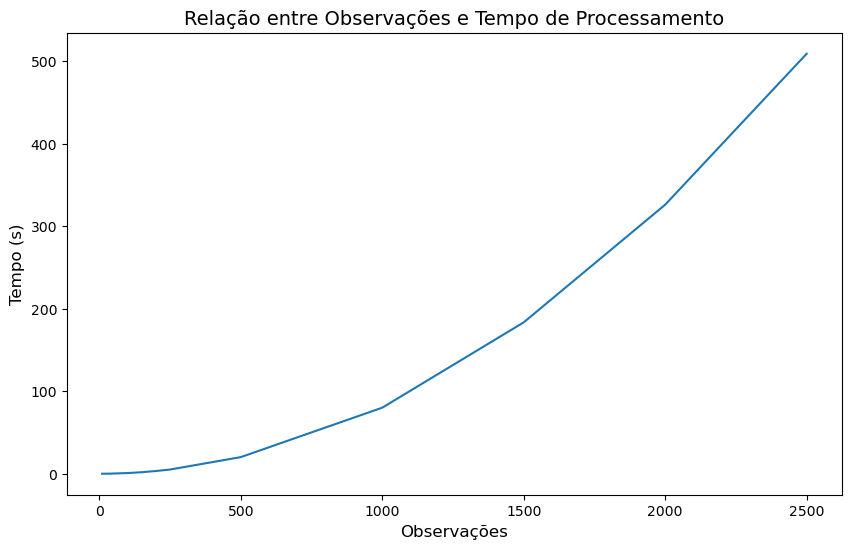

In [24]:
#Calcular o tempo

time_list = []
window_list = [10, 20, 30, 40, 100, 150, 200, 250, 500, 1000, 1500, 2000, 2500]


for window in window_list:

    # Início do tempo de processamento
    start_time = time.time()
    
    # Parâmetros
    n = 10  # Número de termos principais a serem mantidos
    threshold = 0.5  # Threshold de similaridade
    # Processar os DataFrames
    _1, _2, _3 = process_dataframes(df1[:window], df2[:window], n, threshold)

    # Fim do tempo de processamento
    end_time = time.time()
    
    # Cálculo do tempo total
    time_list.append(end_time - start_time)

#Plotando gráfico de Observações vs. Tempo
plt.figure(figsize=(10, 6))
plt.plot(window_list, time_list)
plt.title("Relação entre Observações e Tempo de Processamento", fontsize=14)
plt.xlabel("Observações", fontsize=12)
plt.ylabel("Tempo (s)", fontsize=12)
plt.show()

## Considerações Finais

Conforme mostrado no gráfico acima, o modelo proposto para calcular a similaridade de produtos não se mostrou eficiente. Apesar de utilizar técnicas conhecidas, a falta de otimização do código torna o processamento excessivamente custoso, especialmente em função do volume de informações.

Para um cenário real, é essencial explorar soluções de processamento mais eficientes, como por exemplo a utilização de técnicas de processamento em batches para reutilização de informações repetidas. Armazenar informações em arquiteturas otimizadas, como as oferecidas por grandes provedores como Amazon, Google e Microsoft, além de paralelizar as tarefas, são fatores cruciais. Além disso, o uso de LLMs por meio de APIs tem se mostrado uma excelente opção para atividades de processamento de linguagem, destacando-se pela precisão em comparação aos modelos clássicos de NLP.